In [65]:
# Load NeuroKit and other useful packages
%matplotlib widget


import neurokit2 as nk

import numpy as np 
import pandas as pd
import os

import csv
import itertools
import collections
import pywt

from scipy import stats

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [66]:
def denoise(data): 
    w = pywt.Wavelet('sym4')
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    threshold = 0.04 # Threshold for filtering

    coeffs = pywt.wavedec(data, 'sym4', level=maxlev)
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        
    datarec = pywt.waverec(coeffs, 'sym4')
    
    return datarec

In [67]:
path = '../Fractal Analysis//mitbih_database/'
window_size = 1250
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

Reading in 1st Signal

In [68]:
# Read files
filenames = next(os.walk(path))[2]

# Split and save .csv , .txt 
records = list()
annotations = list()
filenames.sort()



In [69]:
# segrefating filenames and annotations
for f in filenames:
    filename, file_extension = os.path.splitext(f)
    
    # *.csv
    if(file_extension == '.csv'):
        records.append(path + filename + file_extension)

    # *.txt
    else:
        annotations.append(path + filename + file_extension)




Data Extraction and Preprocessing


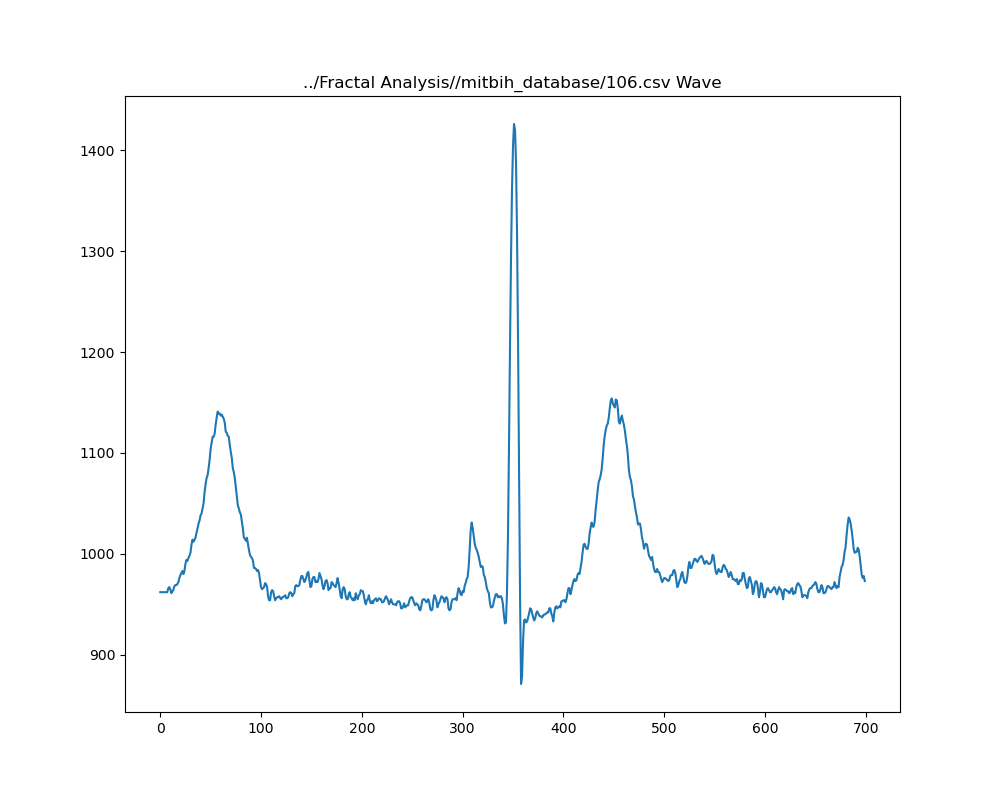

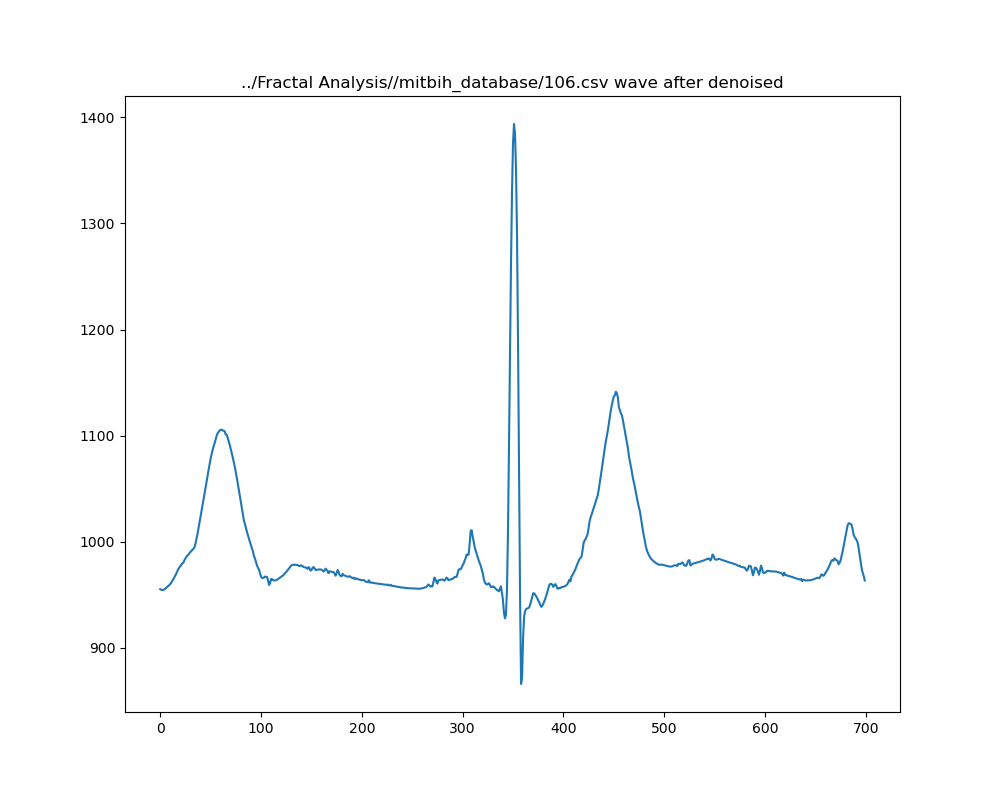

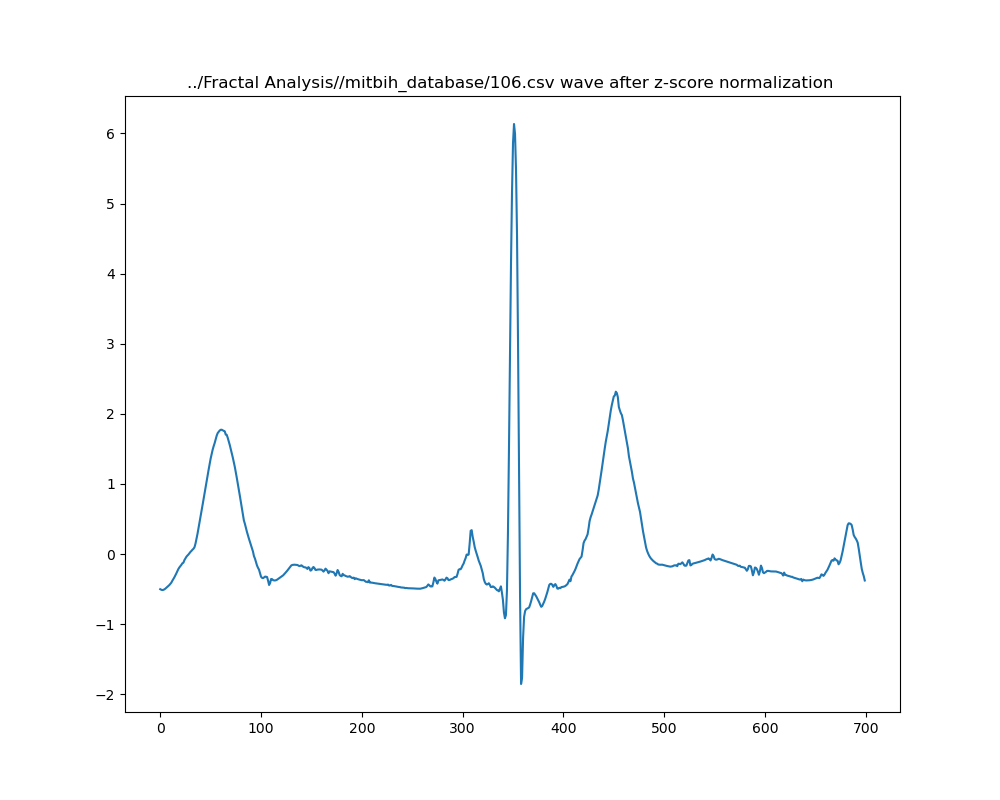

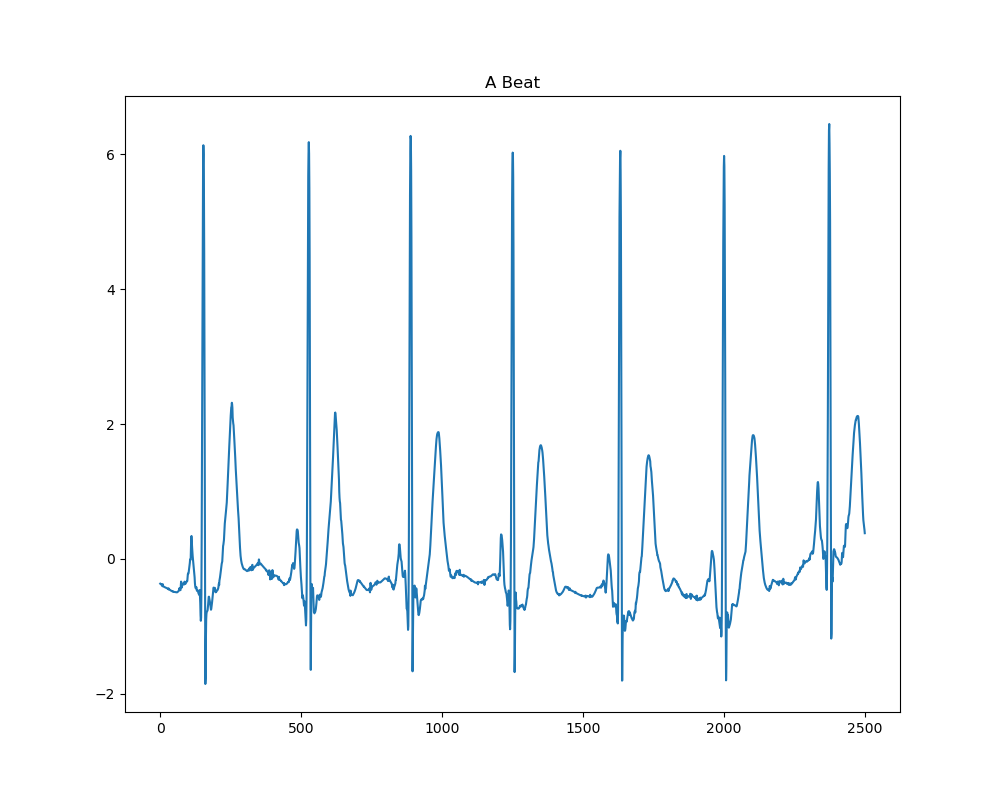

(99674, 2500) (99674,)


In [70]:
# Records
for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1
        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1
            
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.figure(figsize=(10,8))
        plt.title(records[6] + " Wave")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = denoise(signals)
    # Plot an example to the signals
    if r == 6:
        #Plot each patient's signal
        plt.figure(figsize=(10,8))
        plt.title(records[6] + " wave after denoised")
        plt.plot(signals[0:700])
        plt.show()
        
    signals = stats.zscore(signals)
    #signals = remove_baseline_wander(signals, sample_rate = 360.0)
    # Plot an example to the signals
    if r == 6:
        # Plot each patient's signal
        plt.figure(figsize=(10,8))
        plt.title(records[6] + " wave after z-score normalization ")
        plt.plot(signals[0:700])
        plt.show()
    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ') #The split() method splits a string into a list.
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
           # if count_classes[arrhythmia_index] > maximum_counting: # avoid overfitting
                #    pass
            #else:
                count_classes[arrhythmia_index] += 1
                if(window_size <= pos and pos < (len(signals) - window_size)):
                    beat = signals[pos-window_size:pos+window_size]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    if r == 6 and not example_beat_printed: 
                        plt.figure(figsize=(10,8))
                        plt.title("A Beat")
                        plt.plot(beat)
                        plt.show()
                        example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)

# data shape
print(np.shape(X), np.shape(y))

In [7]:
signals.shape

(650000,)

0


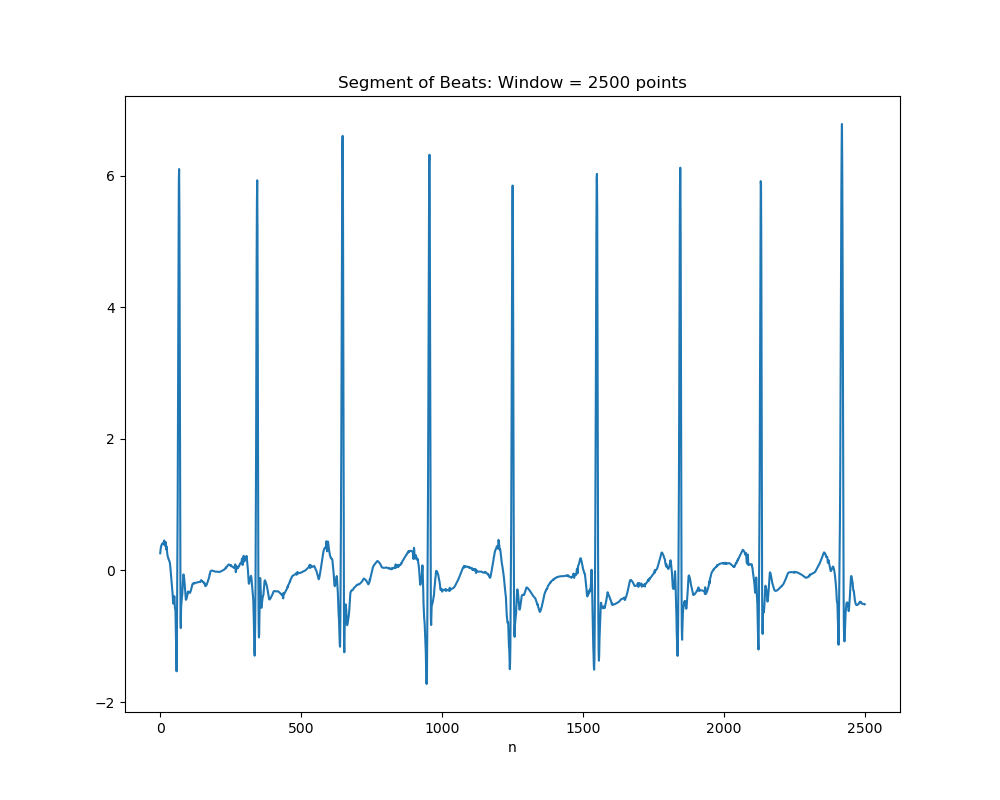

In [72]:
plt.figure(figsize=(10,8))
plt.plot(X[10])
plt.title('Segment of Beats: Window = 2500 points')
plt.xlabel('n')
print(y[10])

In [73]:
count_classes

[75052, 8075, 7259, 2546, 7130]

In [74]:
for i in range(0,len(X)):
        X[i] = np.append(X[i], y[i])
#         X[i].append(y[i])

print(np.shape(X))

(99674, 2501)


0.0    74754
1.0     8049
2.0     7229
4.0     7108
3.0     2534
Name: 2500, dtype: int64


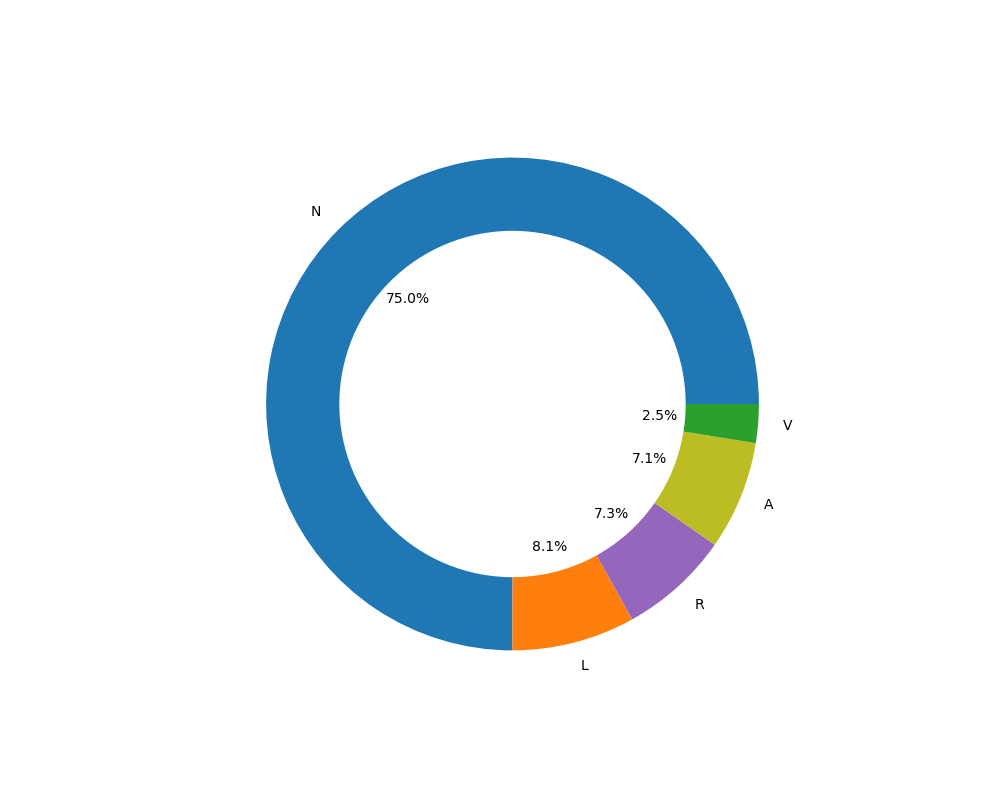

In [75]:
X_train_df = pd.DataFrame(X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue', 'tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
X_train_df

Rebalancing Classes

df_1=X_train_df[X_train_df[X_train_df.shape[1]-1]==1]
df_2=X_train_df[X_train_df[X_train_df.shape[1]-1]==2]
df_3=X_train_df[X_train_df[X_train_df.shape[1]-1]==3]
df_4=X_train_df[X_train_df[X_train_df.shape[1]-1]==4]

df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=5000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=5000,random_state=122)
df_2_upsample=resample(df_2,replace=True,n_samples=5000,random_state=123)
df_3_upsample=resample(df_3,replace=True,n_samples=5000,random_state=124)
df_4_upsample=resample(df_4,replace=True,n_samples=5000,random_state=125)
# df_5_upsample=resample(df_5,replace=True,n_samples=5000,random_state=126)

# X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample,df_5_upsample])
X_train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [76]:
df_1=(X_train_df[X_train_df[X_train_df.shape[1]-1]==1]).sample(n=2000,random_state=42)
df_2=(X_train_df[X_train_df[X_train_df.shape[1]-1]==2]).sample(n=2000,random_state=42)
df_3=(X_train_df[X_train_df[X_train_df.shape[1]-1]==3]).sample(n=2000,random_state=42)
df_4=(X_train_df[X_train_df[X_train_df.shape[1]-1]==4]).sample(n=2000,random_state=42)

df_0=(X_train_df[X_train_df[X_train_df.shape[1]-1]==0]).sample(n=2000,random_state=42)

X_train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])


0.0    2000
1.0    2000
2.0    2000
3.0    2000
4.0    2000
Name: 2500, dtype: int64


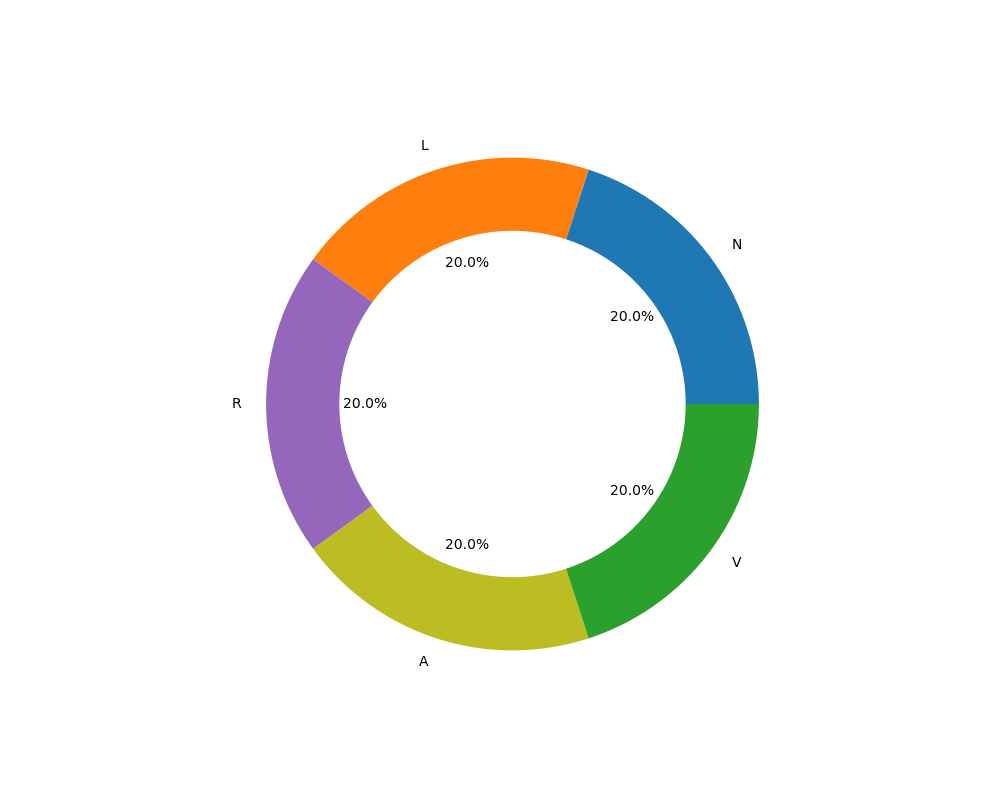

In [77]:
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10,8))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'A', 'V'], colors=['tab:blue', 'tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()


In [80]:
bdf = X_train_df.drop(['Type'], axis=1)
beatdata = bdf.to_numpy()

In [81]:
beatdata.shape

(10000, 2500)

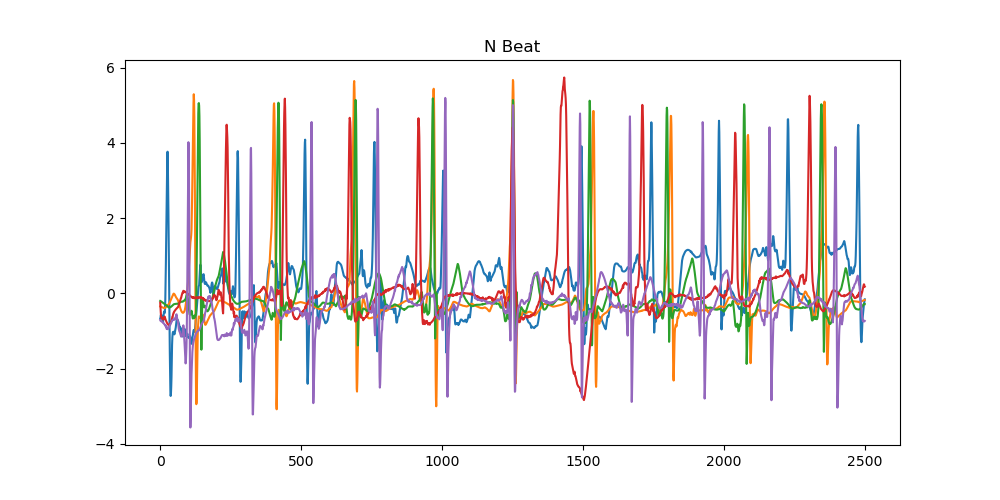

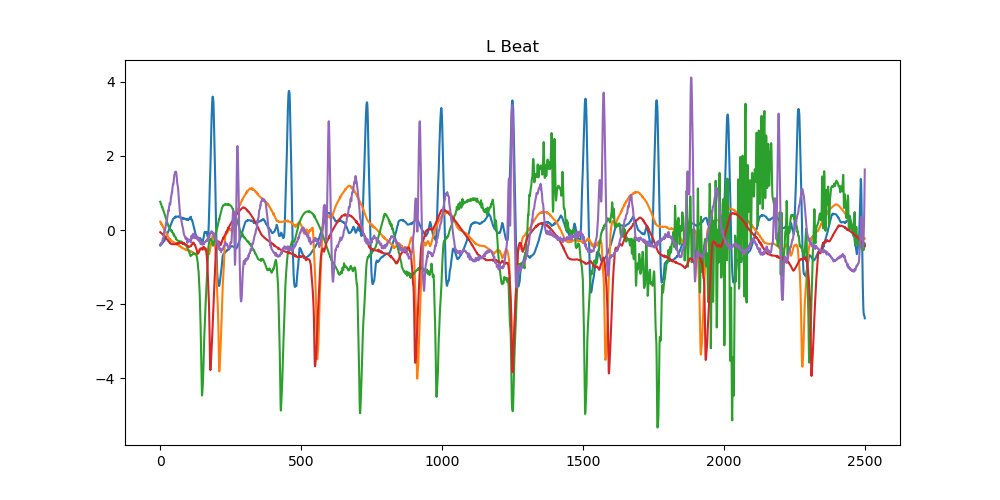

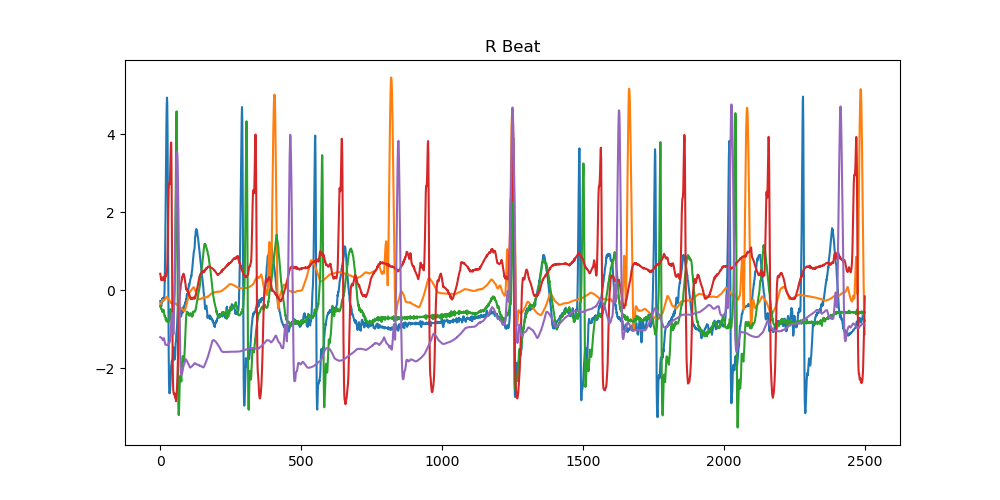

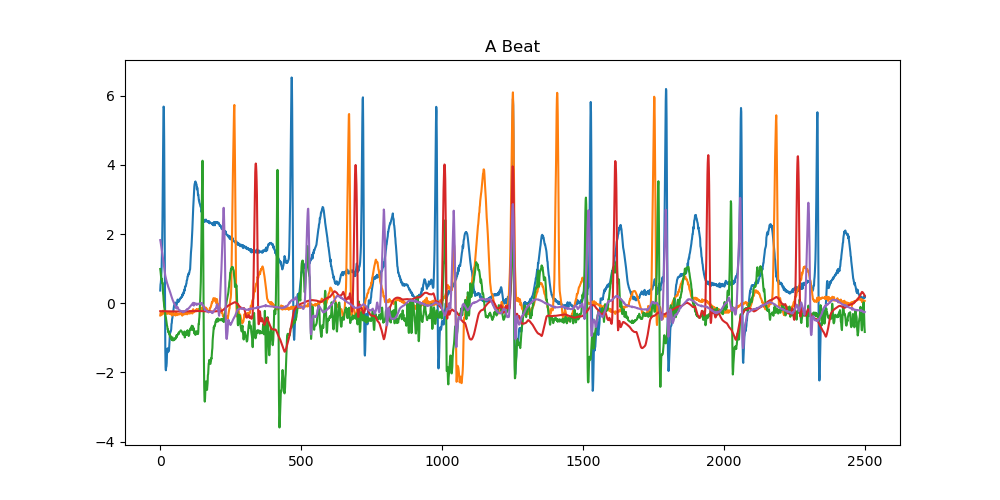

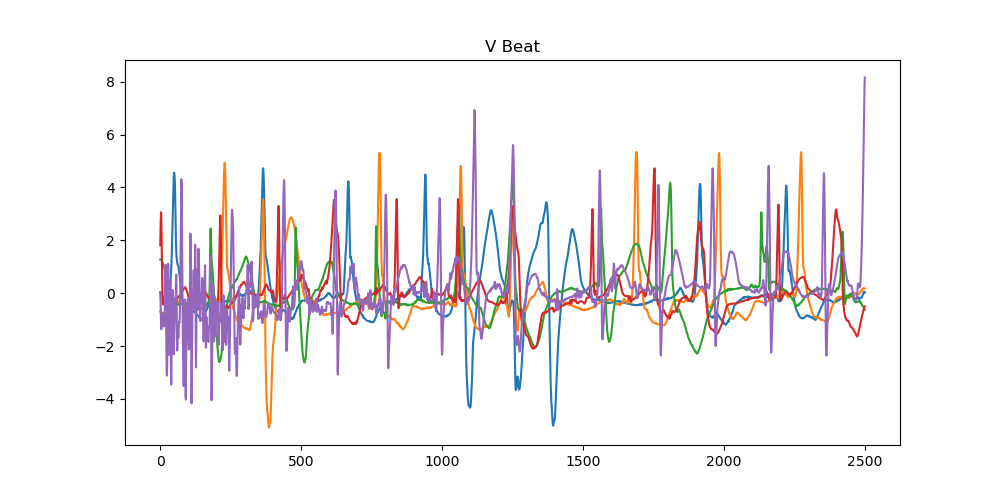

In [82]:
fig = plt.figure(figsize=(10,5))
plt.title("N Beat")
for i in range(5):
    plt.plot(beatdata[i])


fig = plt.figure(figsize=(10,5))
plt.title("L Beat")
for i in range(5):
    plt.plot(beatdata[i+2001])


fig = plt.figure(figsize=(10,5))
plt.title("R Beat")
for i in range(5):
    plt.plot(beatdata[4001+i])


fig = plt.figure(figsize=(10,5))
plt.title("A Beat")
for i in range(5):
    plt.plot(beatdata[6001+i])


fig = plt.figure(figsize=(10,5))
plt.title("V Beat")
for i in range(5):
    plt.plot(beatdata[8001+i])


Feature Extraction

In [83]:
from distutils.log import debug
from sklearn.preprocessing import StandardScaler
from hfd import hfd, curve_length, lin_fit_hfd
import time

Higuchi Fractal Dimension


In [84]:
def apply_hfd(x,name=None):
    print("##################")
    print("#### "+str(name))
    print("##################")    
    ## HFD, not optimized
    print("*** HFD")
    t = time.time()
    print("\tHFD=",hfd(x,opt=False))
    print("\ttiming:",time.time() - t)
    ##
    print("*** step-by-step (not-optimized)")
    t = time.time()
    k, L = curve_length(x,opt=False)
    HFD = lin_fit_hfd(np.log2(k),np.log2(L),log=False)
    print("\tHFD=",HFD)
    print("\ttiming:",time.time()-t)

    plt.plot(np.log2(k),np.log2(L),'.')
    plt.annotate("HFD = "+"{:.2f}".format(HFD),(0.05,0.1),xycoords='axes fraction')
    plt.xlabel('Log interval')
    plt.ylabel('Log curve length')
    if name:
        plt.title(name)

    return HFD

##################
#### Normal
##################
*** HFD
	HFD= 1.8526886295121678
	timing: 0.22183823585510254
*** step-by-step (not-optimized)
	HFD= 1.8526886295121678
	timing: 0.12741994857788086
##################
#### Normal
##################
*** HFD
	HFD= 1.7398535072226606
	timing: 0.12174630165100098
*** step-by-step (not-optimized)
	HFD= 1.7398535072226606
	timing: 0.11067414283752441
##################
#### Normal
##################
*** HFD
	HFD= 1.8483241744228869
	timing: 0.11683154106140137
*** step-by-step (not-optimized)
	HFD= 1.8483241744228869
	timing: 0.13877034187316895
##################
#### Normal
##################
*** HFD
	HFD= 1.771256796167971
	timing: 0.134657621383667
*** step-by-step (not-optimized)
	HFD= 1.771256796167971
	timing: 0.11998796463012695
##################
#### LBBB
##################
*** HFD
	HFD= 1.7533197367711224
	timing: 0.11536192893981934
*** step-by-step (not-optimized)
	HFD= 1.7533197367711224
	timing: 0.11562466621398926
###########

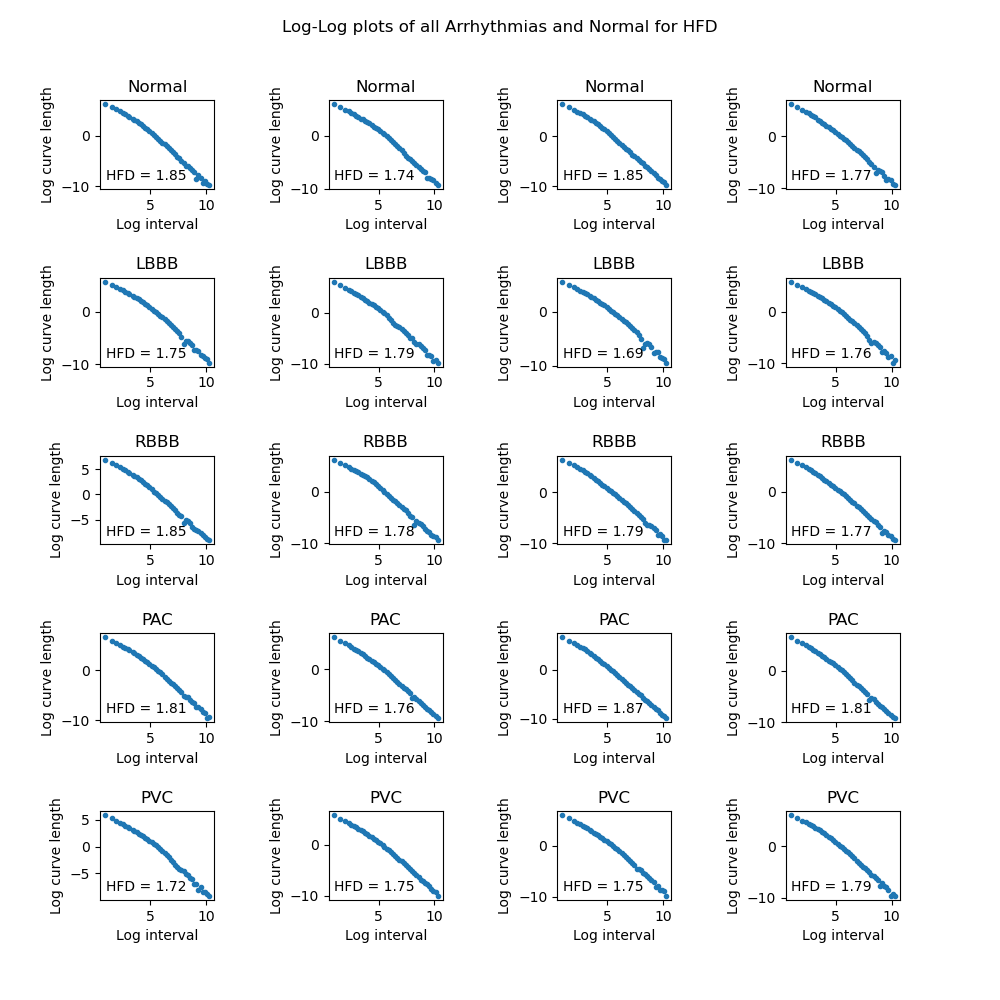

In [85]:
fig = plt.figure(figsize=(10,10))
plt.suptitle("Log-Log plots of all Arrhythmias and Normal for HFD")
plt.subplot(5,4,1)
apply_hfd(beatdata[1],"Normal")
plt.subplot(5,4,2)
apply_hfd(beatdata[124],"Normal")
plt.subplot(5,4,3)
apply_hfd(beatdata[354],"Normal")
plt.subplot(5,4,4)
apply_hfd(beatdata[153],"Normal")


plt.subplot(5,4,5)
apply_hfd(beatdata[2011],"LBBB")
plt.subplot(5,4,6)
apply_hfd(beatdata[2005],"LBBB")
plt.subplot(5,4,7)
apply_hfd(beatdata[2012],"LBBB")
plt.subplot(5,4,8)
apply_hfd(beatdata[2543],"LBBB")

plt.subplot(5,4,9)
apply_hfd(beatdata[4334],"RBBB")
plt.subplot(5,4,10)
apply_hfd(beatdata[4443],"RBBB")
plt.subplot(5,4,11)
apply_hfd(beatdata[5602],"RBBB")
plt.subplot(5,4,12)
apply_hfd(beatdata[5023],"RBBB")

plt.subplot(5,4,13)
apply_hfd(beatdata[6043],"PAC")
plt.subplot(5,4,14)
apply_hfd(beatdata[6023],"PAC")
plt.subplot(5,4,15)
apply_hfd(beatdata[7543],"PAC")
plt.subplot(5,4,16)
apply_hfd(beatdata[7345],"PAC")

plt.subplot(5,4,17)
apply_hfd(beatdata[8023],"PVC")
plt.subplot(5,4,18)
apply_hfd(beatdata[8065],"PVC")
plt.subplot(5,4,19)
apply_hfd(beatdata[9064],"PVC")
plt.subplot(5,4,20)
apply_hfd(beatdata[9034],"PVC")


plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=1,
                    hspace=1)
plt.show()


##################
#### 10s
##################
*** HFD
	HFD= 1.890852168482469
	timing: 2.985018730163574
*** step-by-step (not-optimized)
	HFD= 1.890852168482469
	timing: 2.891268730163574


1.890852168482469

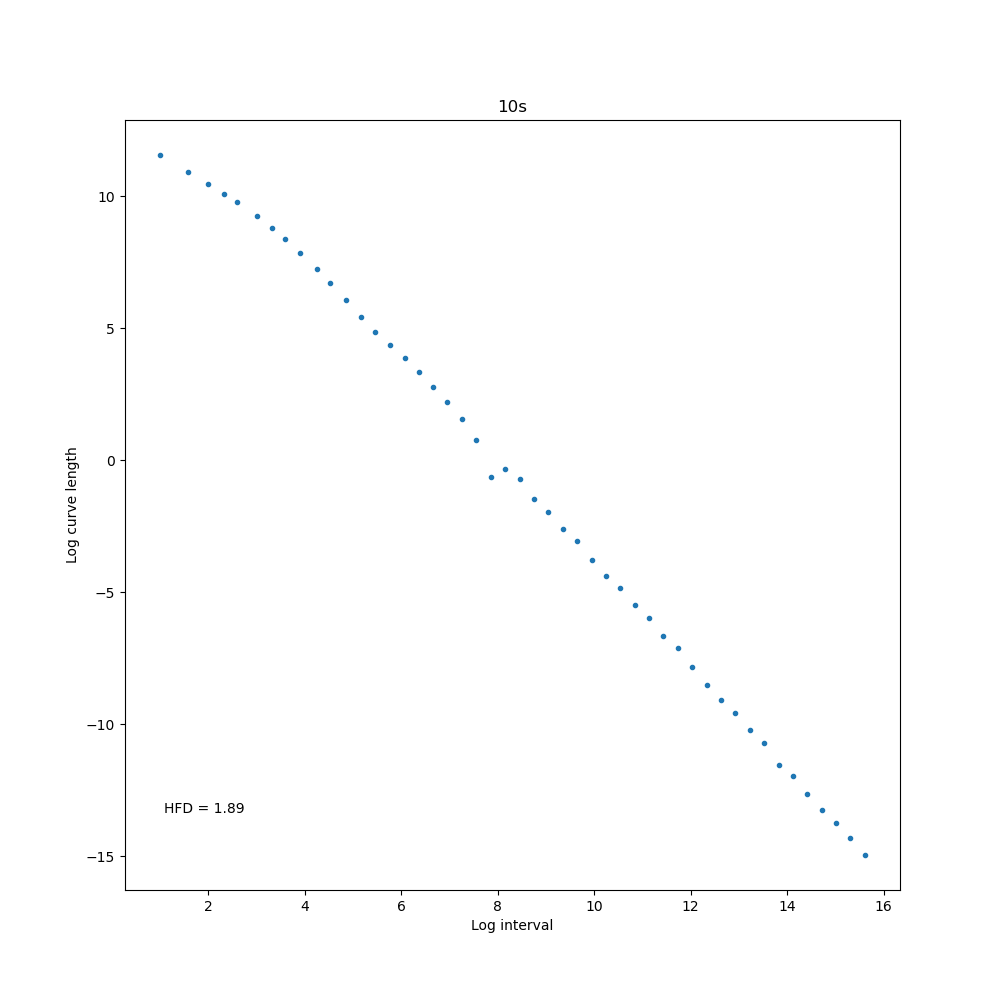

In [22]:
fig = plt.figure(figsize=(10,10))
apply_hfd(signals[0:100000],"10s")

C:\Users\Matt Segue\AppData\Local\Temp\ipykernel_36736\3402950149.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  x = np.empty(N,dtype=np.float)


##################
#### Brownian
##################
*** HFD
	HFD= 1.5148094076440142
	timing: 2.066432237625122
*** step-by-step (not-optimized)
	HFD= 1.5148094076440142
	timing: 2.026960611343384


(65536,)

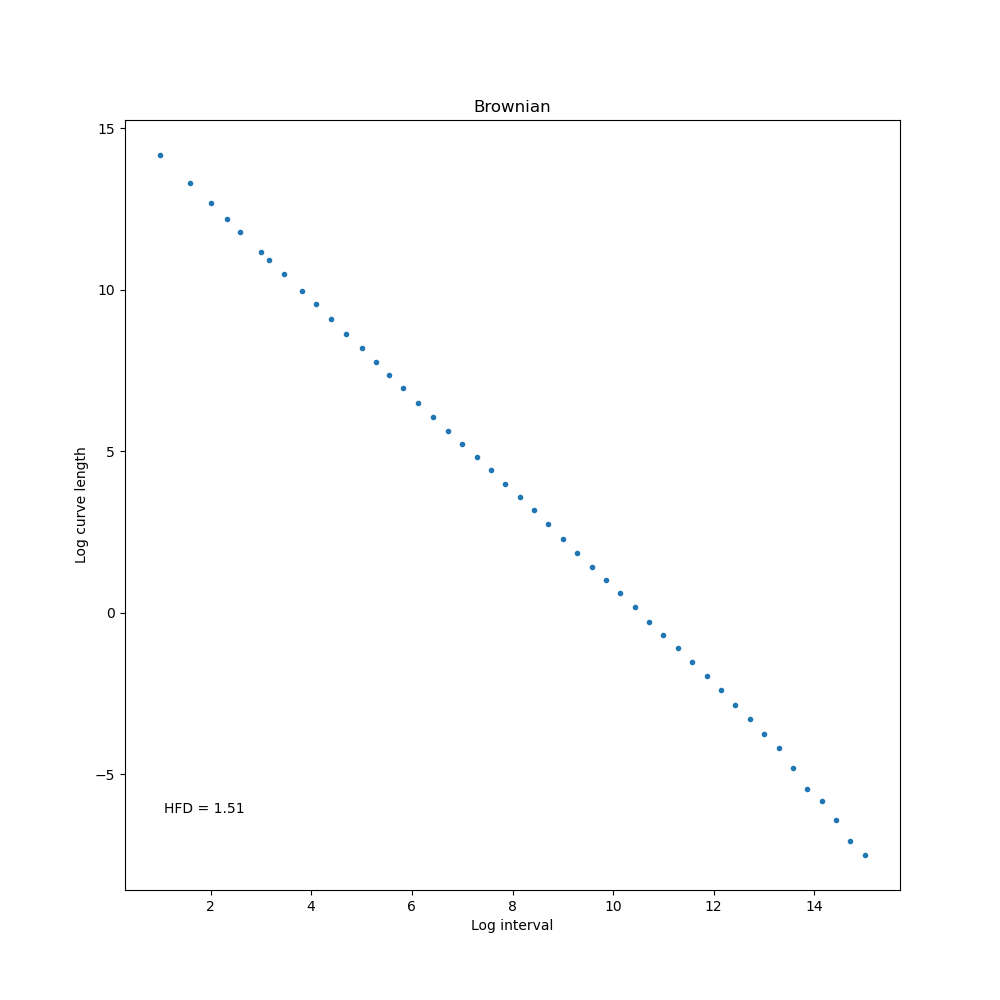

In [23]:
### Higuchi original data: random Gaussian increments = Brownian
fig = plt.figure(figsize=(10,10))
N = 2**16
z = np.random.randn(N+1000)
x = np.empty(N,dtype=np.float)
for i in range(N):
    x[i] = np.sum(z[:(i+1000)])
apply_hfd(x,"Brownian")

x.shape

Multifracatal Detrended Fluctuation Analysis

In [86]:
from MFDFA import MFDFA

# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q = 2
q_list = np.linspace(-10,10,10)
q_list = q_list[q_list!=0.0]

# The order of the polynomial fitting
order = 1

# Obtain the (MF)DFA as
lag0, dfa0 = MFDFA(beatdata[26], lag = lag, q = q_list, order = order, extensions = {'window': 20})
lag1, dfa1 = MFDFA(beatdata[2500], lag = lag, q = q_list, order = order, extensions = {'window': 20})
lag2, dfa2 = MFDFA(beatdata[4001], lag = lag, q = q_list, order = order, extensions = {'window': 20})
lag3, dfa3 = MFDFA(beatdata[6501], lag = lag, q = q_list, order = order, extensions = {'window': 20})
lag4, dfa4 = MFDFA(beatdata[8501], lag = lag, q = q_list, order = order, extensions = {'window': 20})

Estimated H = 2.992
Estimated H = 1.715
Estimated H = 1.640
Estimated H = 1.960
Estimated H = 2.977


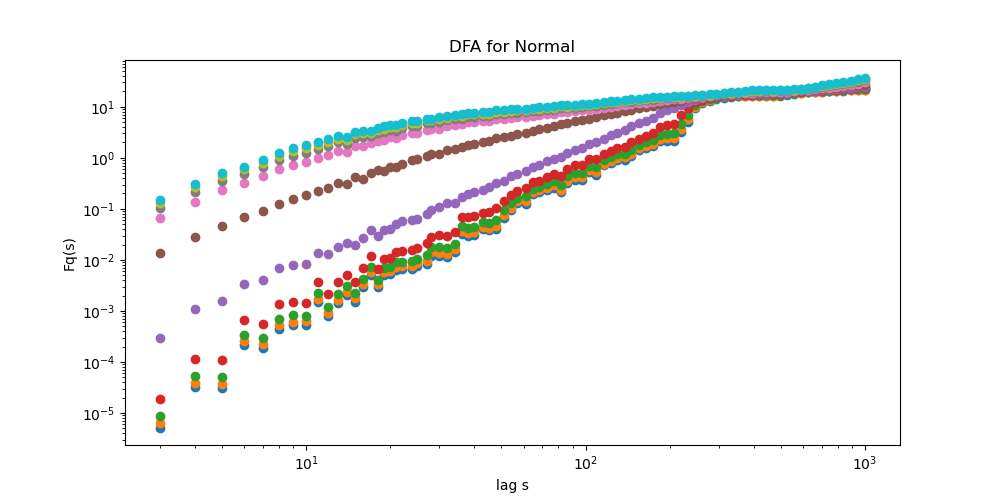

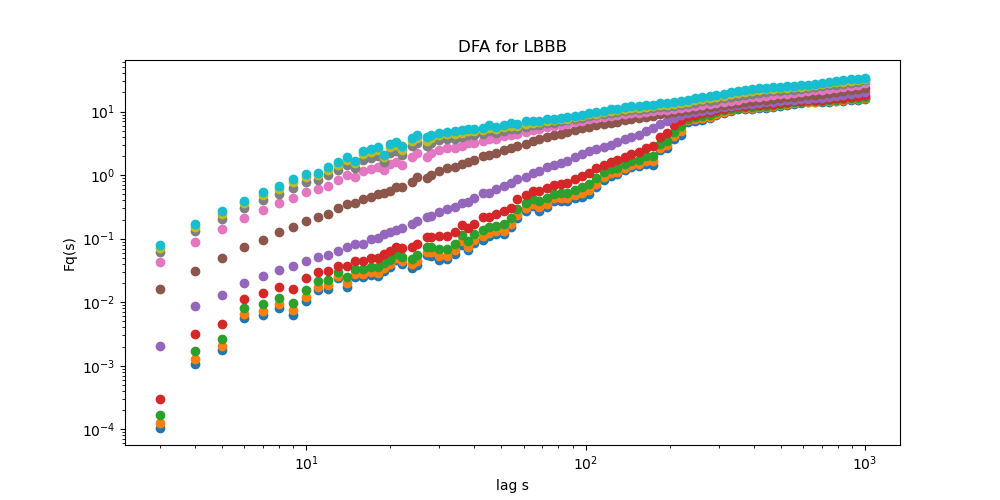

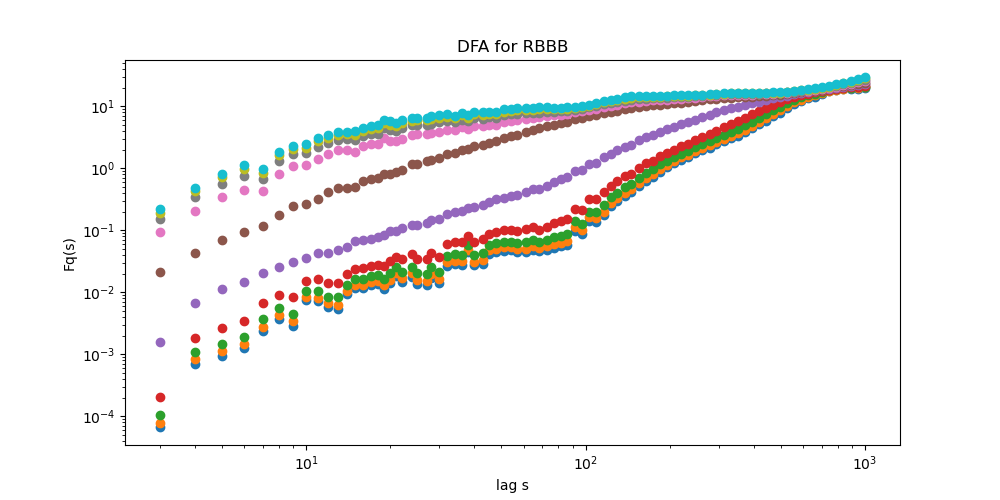

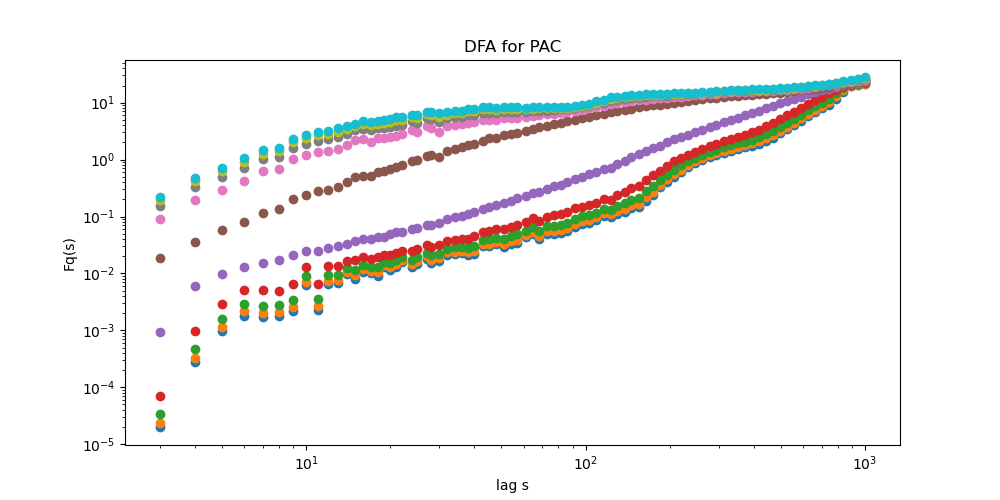

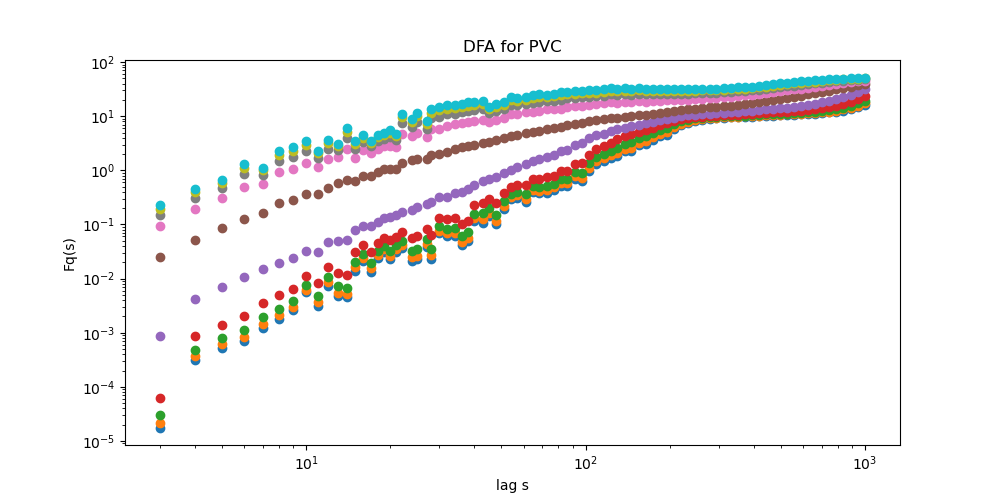

In [87]:
fig = plt.figure(figsize=(10,5))
plt.title('DFA for Normal')
plt.loglog(lag0, dfa0, 'o', label='fOU: MFDFA q=2')
plt.xlabel('lag s')
plt.ylabel('Fq(s)')

# And now we need to fit the line to find the slope. Don't
# forget that since you are plotting in a double logarithmic
# scales, you need to fit the logs of the results
H_hat0 = np.polyfit(np.log(lag0)[4:20],np.log(dfa0[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1

print('Estimated H = '+'{:.3f}'.format(H_hat0[0]))

fig = plt.figure(figsize=(10,5))
plt.title('DFA for LBBB')
plt.loglog(lag1, dfa1, 'o', label='fOU: MFDFA q=2')
plt.xlabel('lag s')
plt.ylabel('Fq(s)')

H_hat1 = np.polyfit(np.log(lag1)[4:20],np.log(dfa1[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1

print('Estimated H = '+'{:.3f}'.format(H_hat1[0]))

fig = plt.figure(figsize=(10,5))
plt.title('DFA for RBBB')
plt.loglog(lag2, dfa2, 'o', label='fOU: MFDFA q=2')
plt.xlabel('lag s')
plt.ylabel('Fq(s)')

H_hat2 = np.polyfit(np.log(lag2)[4:20],np.log(dfa2[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1

print('Estimated H = '+'{:.3f}'.format(H_hat2[0]))

fig = plt.figure(figsize=(10,5))
plt.title('DFA for PAC')
plt.loglog(lag3, dfa3, 'o', label='fOU: MFDFA q=2')
plt.xlabel('lag s')
plt.ylabel('Fq(s)')

H_hat3 = np.polyfit(np.log(lag3)[4:20],np.log(dfa3[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1

print('Estimated H = '+'{:.3f}'.format(H_hat3[0]))

fig = plt.figure(figsize=(10,5))
plt.title('DFA for PVC')
plt.loglog(lag4, dfa4, 'o', label='fOU: MFDFA q=2')
plt.xlabel('lag s')
plt.ylabel('Fq(s)')

H_hat4 = np.polyfit(np.log(lag4)[4:20],np.log(dfa4[4:20]),1)[0]

# Now what you should obtain is: slope = H + 1

print('Estimated H = '+'{:.3f}'.format(H_hat4[0]))

In [24]:
H_hat2

array([2.37796876, 2.32283092, 2.21747659, 1.99707041, 1.77994863,
       1.7901298 , 1.50915079, 1.42751702, 1.39139042, 1.36934304])

In [25]:
print('H0' , np.ptp(H_hat0))

print('H1' , np.ptp(H_hat1))

print('H2' , np.ptp(H_hat2))

print('H3' , np.ptp(H_hat3))

print('H4' , np.ptp(H_hat4))

H0 0.4675342797008759
H1 0.9263067329317338
H2 1.008625714823893
H3 1.7617182005678942
H4 0.8377305321411102


Katz Fractal Dimension

In [128]:
def katz_fd(x, axis=-1):
    x = np.asarray(x)
    dists = np.abs(np.diff(x, axis=axis))
    ll = dists.sum(axis=axis)
    ln = np.log10(ll / dists.mean(axis=axis))
    aux_d = x - np.take(x, indices=[0], axis=axis)
    d = np.max(np.abs(aux_d), axis=axis)
    kfd = np.squeeze(ln / (ln + np.log10(d / ll)))
    if not kfd.ndim:
        kfd = kfd.item()
    return kfd

Petrosian Fractal Dimension

In [167]:
def num_zerocross(x, normalize=False, axis=-1):
    x = np.asarray(x)
    # https://stackoverflow.com/a/29674950/10581531
    nzc = np.diff(np.signbit(x), axis=axis).sum(axis=axis)
    if normalize:
        nzc = nzc / x.shape[axis]
    return nzc

In [168]:
def petrosian_fd(x, axis=-1):
    
    x = np.asarray(x)
    N = x.shape[axis]
    # Number of sign changes in the first derivative of the signal
    nzc_deriv = num_zerocross(np.diff(x, axis=axis), axis=axis)
    pfd = np.log10(N) / (np.log10(N) + np.log10(N / (N + 0.4 * nzc_deriv)))
    return pfd

Correlation Dimension

(2500,)

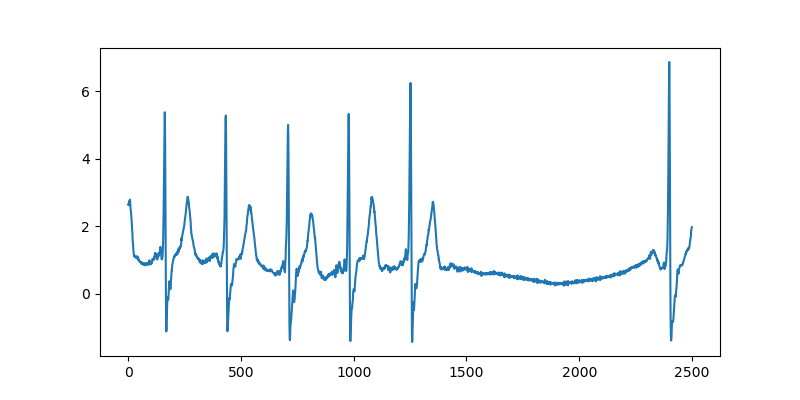

In [266]:
fig = plt.figure(figsize=(8,4))
plt.plot(beatdata[6000])

beatdata[6000].shape

Feature Calculation

In [268]:
import nolds
cd0 = np.zeros(2000)
cd1 = np.zeros(2000)
cd2 = np.zeros(2000)
cd3 = np.zeros(2000)
cd4 = np.zeros(2000)

for i in range(0,2000):

    cd0[i] = nolds.corr_dim(beatdata[i], 10)

    cd1[i] = nolds.corr_dim(beatdata[i+2000], 10)

    cd2[i] = nolds.corr_dim(beatdata[i+4000], 10)

    cd3[i] = nolds.corr_dim(beatdata[i+6000], 10)

    cd4[i] = nolds.corr_dim(beatdata[i+8000], 10)



In [169]:
pfd0 = np.zeros(2000)
pfd1 = np.zeros(2000)
pfd2 = np.zeros(2000)
pfd3 = np.zeros(2000)
pfd4 = np.zeros(2000)

for i in range(0,2000):
    pfd0[i] = petrosian_fd(beatdata[i])
    pfd1[i] = petrosian_fd(beatdata[2000+i])
    pfd2[i] = petrosian_fd(beatdata[4000+i])
    pfd3[i] = petrosian_fd(beatdata[6000+i])
    pfd4[i] = petrosian_fd(beatdata[8000+i])

In [153]:
katz0 = np.zeros(2000)
katz1 = np.zeros(2000)
katz2 = np.zeros(2000)
katz3 = np.zeros(2000)
katz4 = np.zeros(2000)

for i in range(0,2000):
    katz0[i] = katz_fd(beatdata[i])
    katz1[i] = katz_fd(beatdata[2000+i])
    katz2[i] = katz_fd(beatdata[4000+i])
    katz3[i] = katz_fd(beatdata[6000+i])
    katz4[i] = katz_fd(beatdata[8000+i])

In [88]:
fdim0 = np.zeros(2000)
fdim1 = np.zeros(2000)
fdim2 = np.zeros(2000)
fdim3 = np.zeros(2000)
fdim4 = np.zeros(2000)

for i in range(0,2000):
    fdim0[i] = hfd(beatdata[i], opt = False)
    fdim1[i] = hfd(beatdata[2000+i], opt = False)
    fdim2[i] = hfd(beatdata[4000+i], opt = False)
    fdim3[i] = hfd(beatdata[6000+i], opt = False)
    fdim4[i] = hfd(beatdata[8000+i], opt = False)


In [89]:
# Select a band of lags, which usually ranges from
# very small segments of data, to very long ones, as
lag = np.unique(np.logspace(0.5, 3, 100).astype(int))
# Notice these must be ints, since these will segment
# the data into chucks of lag size

# Select the power q
q_list = np.linspace(-10,10,10)
q_list = q_list[q_list!=0.0]

# The order of the polynomial fitting
order = 1

In [90]:
mdfa0 = np.zeros(2000)
mdfa1 = np.zeros(2000)
mdfa2 = np.zeros(2000)
mdfa3 = np.zeros(2000)
mdfa4 = np.zeros(2000)

meanDfa0 = np.zeros(2000)
meanDfa1 = np.zeros(2000)
meanDfa2 = np.zeros(2000)
meanDda3 = np.zeros(2000)
meanDfa4 = np.zeros(2000)

maxDfa0 = np.zeros(2000)
maxDfa1 = np.zeros(2000)
maxDfa2 = np.zeros(2000)
maxDfa3 = np.zeros(2000)
maxDfa4 = np.zeros(2000)

minDfa0 = np.zeros(2000)
minDfa1 = np.zeros(2000)
minDfa2 = np.zeros(2000)
minDfa3 = np.zeros(2000)
minDfa4 = np.zeros(2000)



for i in range(0,2000):
   # Obtain the (MF)DFA as
   lag0, dfa0 = MFDFA(beatdata[i], lag = lag, q = q_list, order = order)
   H_hat0 = np.polyfit(np.log(lag0)[4:20],np.log(dfa0[4:20]),1)[0]
   lag1, dfa1 = MFDFA(beatdata[i+2000], lag = lag, q = q_list, order = order)
   H_hat1 = np.polyfit(np.log(lag1)[4:20],np.log(dfa1[4:20]),1)[0]
   lag2, dfa2 = MFDFA(beatdata[i+4000], lag = lag, q = q_list, order = order)
   H_hat2 = np.polyfit(np.log(lag2)[4:20],np.log(dfa2[4:20]),1)[0]
   lag3, dfa3 = MFDFA(beatdata[i+6000], lag = lag, q = q_list, order = order)
   H_hat3 = np.polyfit(np.log(lag3)[4:20],np.log(dfa3[4:20]),1)[0]
   lag4, dfa4 = MFDFA(beatdata[i+8000], lag = lag, q = q_list, order = order)
   H_hat4 = np.polyfit(np.log(lag4)[4:20],np.log(dfa4[4:20]),1)[0]






   mdfa0[i] = np.ptp(H_hat0)
   mdfa1[i] = np.ptp(H_hat1)
   mdfa2[i] = np.ptp(H_hat2)
   mdfa3[i] = np.ptp(H_hat3)
   mdfa4[i] = np.ptp(H_hat4)

   meanDfa0[i] = np.mean(H_hat0) 
   meanDfa1[i] = np.mean(H_hat1) 
   meanDfa2[i] = np.mean(H_hat2) 
   meanDda3[i] = np.mean(H_hat3) 
   meanDfa4[i] = np.mean(H_hat4) 

   maxDfa0[i] = np.max(H_hat0)
   maxDfa1[i] = np.max(H_hat1)
   maxDfa2[i] = np.max(H_hat2)
   maxDfa3[i] = np.max(H_hat3)
   maxDfa4[i] = np.max(H_hat4)

   minDfa0[i] = np.min(H_hat0)
   minDfa1[i] = np.min(H_hat1)
   minDfa2[i] = np.min(H_hat2)
   minDfa3[i] = np.min(H_hat3)
   minDfa4[i] = np.min(H_hat4)


In [91]:
mdfa2

array([1.11955166, 0.41435174, 1.068918  , ..., 0.91124403, 1.529897  ,
       0.8465793 ])

In [269]:
Ndim = np.stack((fdim0, mdfa0, meanDfa0, maxDfa0, minDfa0, katz0, pfd0, cd0, np.zeros(2000)), axis =1)                        #0
Ldim = np.stack((fdim1, mdfa1, meanDfa1, maxDfa1, minDfa1, katz1, pfd1, cd1, (np.zeros(2000)+np.ones(2000))), axis =1)        #1
Rdim = np.stack((fdim2, mdfa2, meanDfa2, maxDfa2, minDfa2, katz2, pfd2, cd2, (np.zeros(2000)+np.ones(2000)*2)), axis =1)      #2
Adim = np.stack((fdim3, mdfa3, meanDda3, maxDfa3, minDfa3, katz3, pfd3, cd3, np.zeros(2000)+np.ones(2000)*3), axis =1)        #3
Vdim = np.stack((fdim4, mdfa4, meanDfa4, maxDfa4, minDfa4, katz4, pfd4, cd4, np.zeros(2000)+np.ones(2000)*4), axis =1)        #4


labels      = np.array(np.concatenate((Ndim[:, 0], Ldim[:, 0], Rdim[:, 0], Adim[:, 0], Vdim[:, 0])), dtype=object)
Xfdim       = np.array(np.concatenate((Ndim[:, 1], Ldim[:, 1], Rdim[:, 1], Adim[:, 1], Vdim[:, 1])), dtype=object)
Xmdfa       = np.array(np.concatenate((Ndim[:, 2], Ldim[:, 2], Rdim[:, 2], Adim[:, 2], Vdim[:, 2])), dtype=object)
XmeanDfa    = np.array(np.concatenate((Ndim[:, 3], Ldim[:, 3], Rdim[:, 3], Adim[:, 3], Vdim[:, 3])), dtype=object)
XmaxDfa     = np.array(np.concatenate((Ndim[:, 4], Ldim[:, 4], Rdim[:, 4], Adim[:, 4], Vdim[:, 4])), dtype=object)
XminDfa     = np.array(np.concatenate((Ndim[:, 5], Ldim[:, 5], Rdim[:, 5], Adim[:, 5], Vdim[:, 5])), dtype=object)
Xkatz       = np.array(np.concatenate((Ndim[:, 6], Ldim[:, 6], Rdim[:, 6], Adim[:, 6], Vdim[:, 6])), dtype=object)
Xpfd        = np.array(np.concatenate((Ndim[:, 7], Ldim[:, 7], Rdim[:, 7], Adim[:, 7], Vdim[:, 7])), dtype=object)
Xcd         = np.array(np.concatenate((Ndim[:, 8], Ldim[:, 8], Rdim[:, 8], Adim[:, 8], Vdim[:, 8])), dtype=object)

#Ndim[:, 4], Ldim[:, 4],  Rdim[:, 4], Adim[:, 4], Vdim[:, 4]


X = np.stack((labels, Xfdim, Xmdfa, XmeanDfa, XmaxDfa, XminDfa, Xkatz, Xpfd, Xcd), axis =1)
df = pd.DataFrame(X, columns = ['HFD', 'MDFA(p2p)','MDFA(mean)', 'MDFA(max)', 'MDFA(min)', 'Katz FD', 'PFD', 'CD','Type'])


In [ ]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(df)

In [270]:
df

HFD MDFA(p2p) MDFA(mean) MDFA(max) MDFA(min)   Katz FD       PFD  \
0     1.802302   1.27891   2.102819  2.823358  1.544448  1.830883  1.006856   
1     1.852689  1.453443   2.041046  2.784778  1.331335  1.712697  1.004102   
2      1.85821  2.330646   2.361085  3.625394  1.294748  1.775871    1.0048   
3     1.739333  0.746719   1.836105  2.239392  1.492673  1.659209  1.014095   
4     1.864956   0.76233   1.331616  1.795335  1.033005  1.864621  1.010455   
...        ...       ...        ...       ...       ...       ...       ...   
9995  1.794063  1.589284   2.238408   3.12761  1.538326  1.927039  1.009257   
9996  1.777532  1.457783   2.112163  2.872378  1.414595  1.826394  1.004461   
9997  1.727793  0.820314   1.860944   2.21985  1.399535  1.639924  1.004441   
9998  1.657135  0.258883   1.782025   1.91912  1.660237  1.451461  1.012389   
9999  1.794065  0.441044   1.539196  1.751841  1.310797  1.728705  1.016884   

            CD Type  
0     2.092688  0.0  
1     1.359354  0.0  
2       1.4377  0.0  
3     1.445684  0.0  
4     1.824323  0.0  
...        ...  ...  
9995   2.02243  4.0  
9996   1.61265  4.0  
9997  1.470786  4.0  
9998  1.155322  4.0  
9999  1.706939  4.0  

[10000 rows x 9 columns]

In [34]:
import seaborn as sn
import pickle
import pandas as pd
#df.to_pickle("n=3000_FractalFeaturesDF500")
#df = pd.read_pickle('FractalFeaturesDF25000_Window = 1500.pkl')


TSNE Visulisation

In [ ]:
from code import interact
from tkinter import Y
from sklearn.manifold import TSNE
import seaborn as sn
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import axes3d 



tsne = TSNE(n_components=3,  random_state=0, perplexity=80,early_exaggeration=6, n_iter=1000, learning_rate = 600, n_iter_without_progress=300, angle=0.5)
labels_25000 = df["Type"]
data_25000 = StandardScaler().fit_transform(df.drop(["Type"], axis=1))
Xtsne = tsne.fit_transform(data_25000)

tsne_data = np.vstack((Xtsne.T, labels_25000)).T

#3 Components
tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component', '3rd Component','Type'))

#2 Components
#tsne_df = pd.DataFrame(tsne_data, columns = ('1st Component', '2nd Component','Type'))



In [ ]:
tsne_df

In [ ]:
#tsne_df.to_pickle("TSNE_df_25000")


Plot TSNE data in 2D and 3D

In [ ]:

sn.set(style = "darkgrid")

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

#Plotting n=3 Components

#2D plot of first two components
sn.FacetGrid(tsne_df, hue = 'Type', aspect = 2, height = 5).map(plt.scatter, '1st Component', '2nd Component').add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle('TSNE  Arrhythmias and Normal ')


#3D plot of all components
x = tsne_df["1st Component"].to_numpy()
y = tsne_df["2nd Component"].to_numpy()
z = tsne_df["3rd Component"].to_numpy()

ax.scatter(x[:200],    y[:200],    z[:200],    s=10,   c = 'red', cmap=plt.cm.prism, label = 0, alpha = 1)                 #0
ax.scatter(x[200:400], y[200:400], z[200:400], s = 10, c = 'green', cmap=plt.cm.prism, label = 1, alpha = 1)         #1
ax.scatter(x[400:600], y[400:600], z[400:600], s = 10, c = 'blue', cmap=plt.cm.prism, label = 2, alpha = 1)       #2
ax.scatter(x[600:800], y[600:800], z[600:800], s = 10, c = 'purple', cmap=plt.cm.prism, label = 3, alpha = 1)     #3
ax.scatter(x[800:1000], y[800:1000], z[800:1000], s = 10, c = 'orange', cmap=plt.cm.prism, label = 4, alpha = 1)     #4

ax.legend()
ax.set_title('TSNE  Arrhythmias and Normal')


for angle in range(0, 360):
   ax.view_init(30, angle)
  
plt.show()

In [ ]:
X_train_df

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(projection='3d')

#Plotting n=3 Components

#2D plot of first two components
sn.FacetGrid(df, hue = 'Type', aspect = 2, height = 5).map(plt.scatter, '').add_legend()
plt.subplots_adjust(top=0.9)
plt.suptitle('TSNE  Arrhythmias and Normal ')

Histograms of Data

In [ ]:
import matplotlib.colors as colors
fig = plt.figure(figsize=(8,4))
plt.title("HFD for all Classes")
sn.histplot(data=df, x='HFD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Higuchi Fractal Dimension')
print(df.groupby("Type")['HFD'].mean())

Detrended Fluctuation Analysis
Type
0.0    1.266422
1.0    0.743246
2.0    1.173917
3.0    0.944209
4.0    1.153036
Name: MDFA(p2p), dtype: float64
Detrended Fluctuation Analysis
Type
0.0    1.897150
1.0    1.906283
2.0    1.868304
3.0    1.547335
4.0    1.950470
Name: MDFA(mean), dtype: float64
Detrended Fluctuation Analysis
Type
0.0    2.573425
1.0    2.317271
2.0    2.488154
3.0    2.067857
4.0    2.565432
Name: MDFA(max), dtype: float64
Detrended Fluctuation Analysis
Type
0.0    1.307003
1.0    1.574025
2.0    1.314237
3.0    1.123647
4.0    1.412396
Name: MDFA(min), dtype: float64


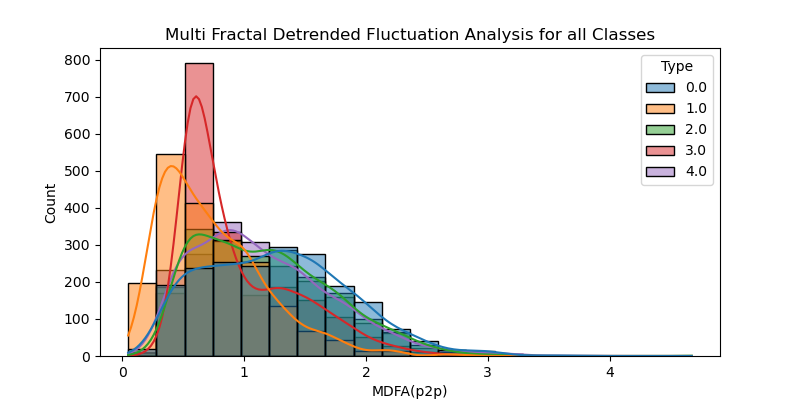

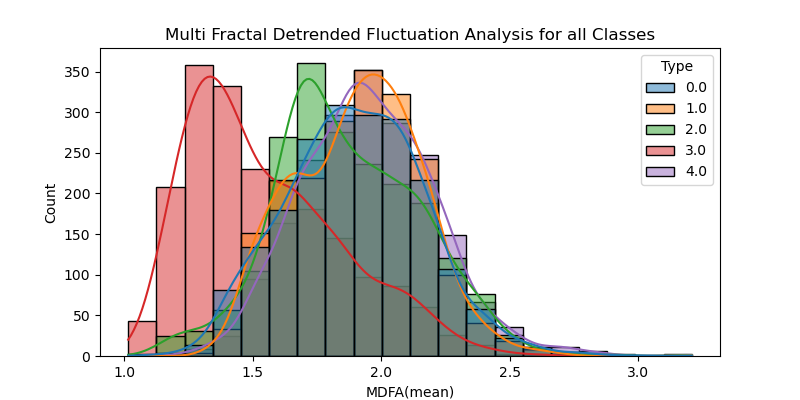

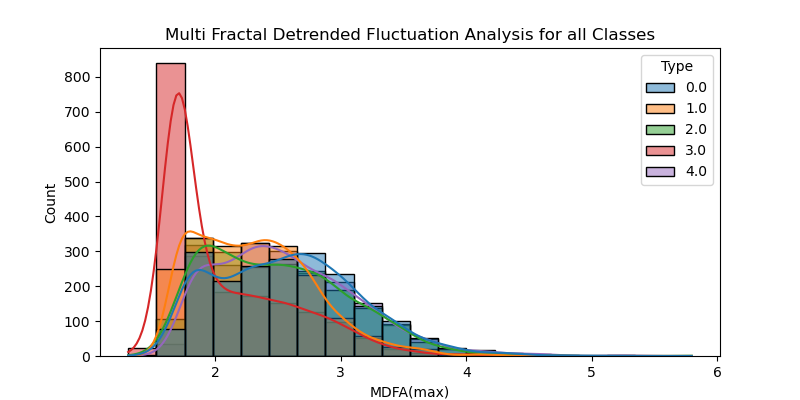

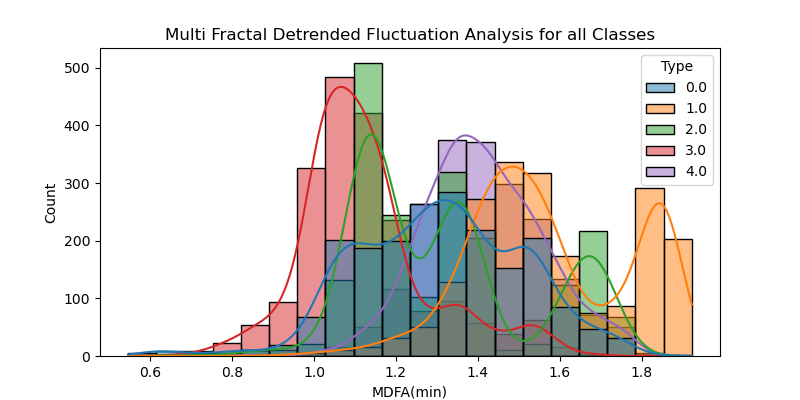

In [426]:
fig = plt.figure(figsize=(8,4))
plt.title("Multi Fractal Detrended Fluctuation Analysis for all Classes")
sn.histplot(data=df, x='MDFA(p2p)', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Detrended Fluctuation Analysis')
print(df.groupby("Type")['MDFA(p2p)'].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Multi Fractal Detrended Fluctuation Analysis for all Classes")
sn.histplot(data=df, x='MDFA(mean)', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Detrended Fluctuation Analysis')
print(df.groupby("Type")['MDFA(mean)'].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Multi Fractal Detrended Fluctuation Analysis for all Classes")
sn.histplot(data=df, x='MDFA(max)', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Detrended Fluctuation Analysis')
print(df.groupby("Type")['MDFA(max)'].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Multi Fractal Detrended Fluctuation Analysis for all Classes")
sn.histplot(data=df, x='MDFA(min)', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Detrended Fluctuation Analysis')
print(df.groupby("Type")['MDFA(min)'].mean())

In [ ]:
fig = plt.figure(figsize=(8,4))
plt.title("Detrended Fluctuation Analysis for all Classes")
sn.histplot(data=df, x='DFA', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Detrended Fluctuation Analysis')
print(df.groupby("Type")['DFA'].mean())



fig = plt.figure(figsize=(8,4))
plt.title("Distribution of Correlation Dimension for all Classes")
sn.histplot(data=df, x='CD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('Correlation Dimension')
print(df.groupby("Type")["CD"].mean())

fig = plt.figure(figsize=(8,4))
plt.title("Distribution of Hurst Exponent for all Classes")
sn.histplot(data=df, x='Hurst', hue = 'Type', bins=20, kde=True, palette = 'tab10').set(xlim=(0.8,1.0))
print('Hurst Exponent')
print(df.groupby("Type")["Hurst"].mean())

#fig = plt.figure(figsize=(8,4))
#plt.title("Distribution of LLE for all Classes")
#sn.histplot(data=df, x='LLE', hue = 'Type', bins=20, kde=True, palette = 'tab10').set(xlim=(0,0.07))
#print('LLE')
#print(df.groupby("Type")["LLE"].mean())



HFD
Type
0.0    1.791898
1.0    1.736921
2.0    1.786578
3.0    1.794801
4.0    1.739720
Name: HFD, dtype: float64


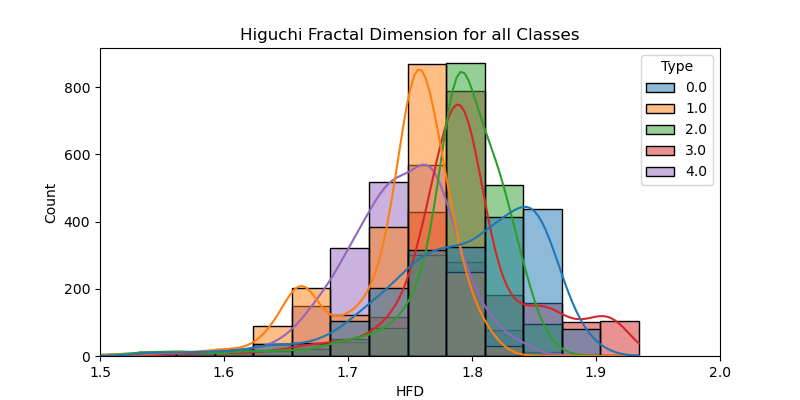

In [427]:
fig = plt.figure(figsize=(8,4))
plt.title("Higuchi Fractal Dimension for all Classes")
sn.histplot(data=df, x='HFD', hue = 'Type', bins=20, kde=True, palette = 'tab10').set(xlim=(1.5,2))
print('HFD')
print(df.groupby("Type")["HFD"].mean())

In [ ]:
df.groupby("Type")["HFD"].mean()

HFD
Type
0.0    1.750653
1.0    1.722417
2.0    1.818509
3.0    1.848284
4.0    1.714600
Name: Katz FD, dtype: float64


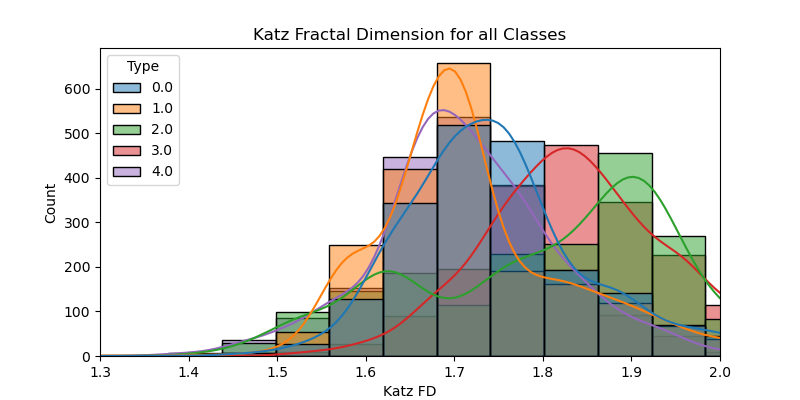

In [428]:
fig = plt.figure(figsize=(8,4))
plt.title("Katz Fractal Dimension for all Classes")
sn.histplot(data=df, x='Katz FD', hue = 'Type', bins=20, kde=True, palette = 'tab10').set(xlim=(1.3,2))
print('HFD')
print(df.groupby("Type")["Katz FD"].mean())

HFD
Type
0.0    1.009410
1.0    1.010547
2.0    1.009395
3.0    1.016135
4.0    1.008558
Name: PFD, dtype: float64


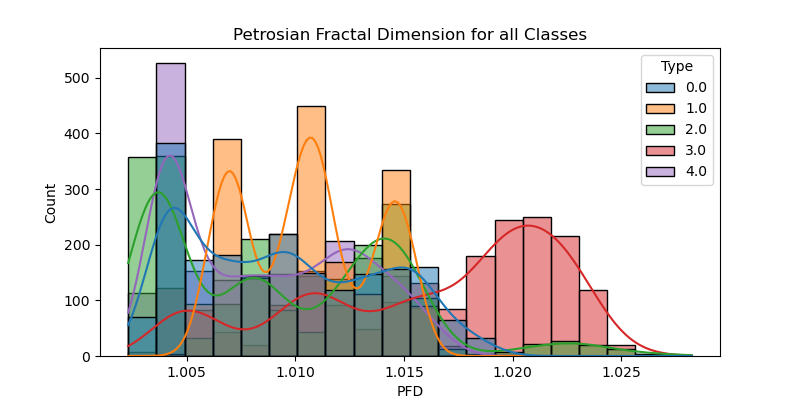

In [177]:
fig = plt.figure(figsize=(8,4))
plt.title("Petrosian Fractal Dimension for all Classes")
sn.histplot(data=df, x='PFD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('HFD')
print(df.groupby("Type")["PFD"].mean())

HFD
Type
0.0    1.704123
1.0    1.810998
2.0    1.776044
3.0    2.126454
4.0    1.609135
Name: CD, dtype: float64


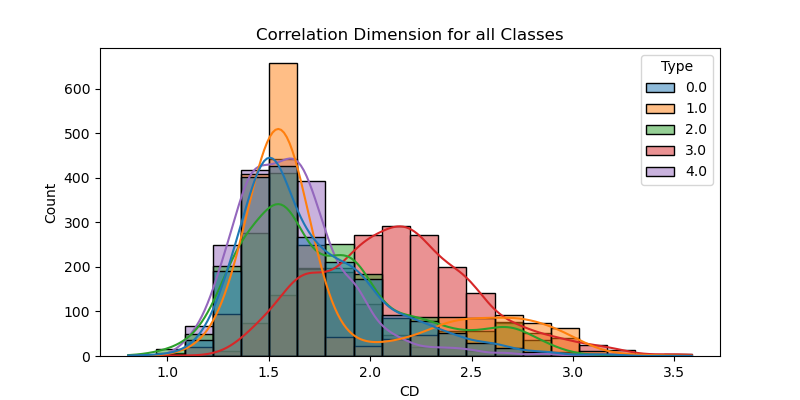

In [429]:
fig = plt.figure(figsize=(8,4))
plt.title("Correlation Dimension for all Classes")
sn.histplot(data=df, x='CD', hue = 'Type', bins=20, kde=True, palette = 'tab10')
print('HFD')
print(df.groupby("Type")["CD"].mean())

In [78]:
cnames = []
for i in range(2500):
    cnames.append(str(i))

cnames.append('Type')

In [79]:
X_train_df.columns =  cnames


In [294]:
import pickle
df.to_pickle('Dataframe_8_features-N_2500-10000_samples.pkl')

HFD MDFA(p2p) MDFA(mean) MDFA(max) MDFA(min)   Katz FD       PFD  \
0     1.802302   1.27891   2.102819  2.823358  1.544448  1.830883  1.006856   
1     1.852689  1.453443   2.041046  2.784778  1.331335  1.712697  1.004102   
2      1.85821  2.330646   2.361085  3.625394  1.294748  1.775871    1.0048   
3     1.739333  0.746719   1.836105  2.239392  1.492673  1.659209  1.014095   
4     1.864956   0.76233   1.331616  1.795335  1.033005  1.864621  1.010455   
...        ...       ...        ...       ...       ...       ...       ...   
7995  1.816333  0.572868   1.517917  1.793467  1.220599  1.999429  1.015785   
7996  1.863722  1.351183   1.777599   2.42763  1.076446  1.777321  1.004322   
7997  1.768254  0.616372   1.292168  1.664884  1.048512   1.74472  1.022748   
7998  1.789885  0.751541   1.257598  1.728853  0.977312  1.844311  1.022009   
7999  1.867534   0.93378   1.398014  1.882422  0.948642   1.97432  1.009915   

            CD Type  
0     2.092688  0.0  
1     1.359354  0.0  
2       1.4377  0.0  
3     1.445684  0.0  
4     1.824323  0.0  
...        ...  ...  
7995  3.200189  3.0  
7996  1.555535  3.0  
7997  2.018171  3.0  
7998   2.33701  3.0  
7999  1.876903  3.0  

[8000 rows x 9 columns]

SVM with on raw data (Limited Dataset)

In [178]:
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [309]:
df

HFD MDFA(p2p) MDFA(mean) MDFA(max) MDFA(min)   Katz FD       PFD  \
0     1.802302   1.27891   2.102819  2.823358  1.544448  1.830883  1.006856   
1     1.852689  1.453443   2.041046  2.784778  1.331335  1.712697  1.004102   
2      1.85821  2.330646   2.361085  3.625394  1.294748  1.775871    1.0048   
3     1.739333  0.746719   1.836105  2.239392  1.492673  1.659209  1.014095   
4     1.864956   0.76233   1.331616  1.795335  1.033005  1.864621  1.010455   
...        ...       ...        ...       ...       ...       ...       ...   
9995  1.794063  1.589284   2.238408   3.12761  1.538326  1.927039  1.009257   
9996  1.777532  1.457783   2.112163  2.872378  1.414595  1.826394  1.004461   
9997  1.727793  0.820314   1.860944   2.21985  1.399535  1.639924  1.004441   
9998  1.657135  0.258883   1.782025   1.91912  1.660237  1.451461  1.012389   
9999  1.794065  0.441044   1.539196  1.751841  1.310797  1.728705  1.016884   

            CD Type  
0     2.092688  0.0  
1     1.359354  0.0  
2       1.4377  0.0  
3     1.445684  0.0  
4     1.824323  0.0  
...        ...  ...  
9995   2.02243  4.0  
9996   1.61265  4.0  
9997  1.470786  4.0  
9998  1.155322  4.0  
9999  1.706939  4.0  

[10000 rows x 9 columns]

Declare feature vector and target variable

In [ ]:
X = X_train_df.drop(['Type'], axis=1)
y = X_train_df['Type'].astype('int')

Split data into separate training and test set 


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [ ]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

Feature Scaling

In [ ]:
cols = X_train.columns

In [ ]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])

In [ ]:
X_train.describe()

Run SVM

In [272]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#rbf svc
svc=SVC(C=100.0) 

#polynomial svc
#poly_svc=SVC(kernel='poly', C=4000) 

#sigmoid svc
#sigmoid_svc=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=50.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=50.0 : 0.7665


SVM with Fractal Features

Declare feature vector and target variable

In [410]:
Xtemp = df.drop(range(4000,10000)) 
X = df.drop(['Type'], axis=1)
X = X.drop(['MDFA(p2p)'], axis =1)



y = df['Type'].astype('int')


Split data into separate training and test set 


In [411]:
# split X and y into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [412]:
# check the shape of X_train and X_test

X_train.shape, X_test.shape

((8000, 7), (2000, 7))

Feature Scaling

In [413]:
cols = X_train.columns

In [414]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [415]:
X_train = pd.DataFrame(X_train, columns=[cols])


In [416]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [417]:
X_train.describe()

HFD    MDFA(mean)     MDFA(max)     MDFA(min)       Katz FD  \
count  8.000000e+03  8.000000e+03  8.000000e+03  8.000000e+03  8.000000e+03   
mean   8.378809e-14  1.236788e-14  8.803624e-15 -5.444534e-15 -3.419487e-14   
std    1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00  1.000063e+00   
min   -7.315041e+00 -2.674405e+00 -1.950348e+00 -3.270129e+00 -4.311350e+00   
25%   -4.419650e-01 -6.650484e-01 -8.627910e-01 -8.205669e-01 -6.940941e-01   
50%    8.880146e-02  3.733413e-02 -1.020468e-01 -4.381688e-03 -1.198877e-01   
75%    5.761904e-01  7.226518e-01  6.747562e-01  6.984809e-01  6.692405e-01   
max    2.634823e+00  4.327073e+00  6.021316e+00  2.394045e+00  4.778600e+00   

                PFD            CD  
count  8.000000e+03  8.000000e+03  
mean   6.805490e-14 -7.226220e-15  
std    1.000063e+00  1.000063e+00  
min   -1.554072e+00 -2.345072e+00  
25%   -8.444316e-01 -7.150760e-01  
50%   -6.483037e-02 -3.129147e-01  
75%    6.791264e-01  5.523096e-01  
max    3.212961e+00  4.182543e+00

Run SVM  


In [420]:
# import SVC classifier
from sklearn.svm import SVC


# import metrics to compute accuracy
from sklearn.metrics import accuracy_score


#rbf svc
svc=SVC(C=100.0, kernel='rbf') 

#polynomial svc
#poly_svc=SVC(kernel='poly', C=4000) 

#sigmoid svc
#sigmoid_svc=SVC(kernel='sigmoid', C=1000.0)

# fit classifier to training set
svc.fit(X_train,y_train)


# make predictions on test set
y_pred=svc.predict(X_test)


# compute and print accuracy score
print('Model accuracy score with rbf kernel and C=100.0 : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score with rbf kernel and C=100.0 : 0.8015


Compare the train-set and test-set accuracy

In [421]:
y_pred_train = svc.predict(X_train)

In [422]:
# print the scores on training and test set

print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.8480
Test set score: 0.8015


In [423]:
# check class distribution in test set
y_test.value_counts()

2    419
4    412
1    398
3    398
0    373
Name: Type, dtype: int64

K-Fold Cross Validation - 10 Splits

In [409]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [393]:
# Create an instance of Pipeline
#
pipeline = make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=100, max_depth=4))
#
# Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
#
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
#
#
#
for k, (train, test) in enumerate(kfold):
    pipeline.fit(X_train.iloc[train, :], y_train.iloc[train])
    score = pipeline.score(X_train.iloc[test, :], y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

Fold:  1, Training/Test Split Distribution: [1465 1441 1423 1441 1430], Accuracy: 0.949
Fold:  2, Training/Test Split Distribution: [1465 1441 1423 1441 1430], Accuracy: 0.953
Fold:  3, Training/Test Split Distribution: [1465 1442 1422 1442 1429], Accuracy: 0.956
Fold:  4, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.963
Fold:  5, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.968
Fold:  6, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.951
Fold:  7, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.948
Fold:  8, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.958
Fold:  9, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.950
Fold: 10, Training/Test Split Distribution: [1464 1442 1423 1442 1429], Accuracy: 0.950


Cross-Validation accuracy: 0.954 +/- 0.006


Confusion matrix 

In [424]:
# Print the Confusion Matrix and slice it into four pieces

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)


Text(0.5, 1.0, 'Confusion Matrix')

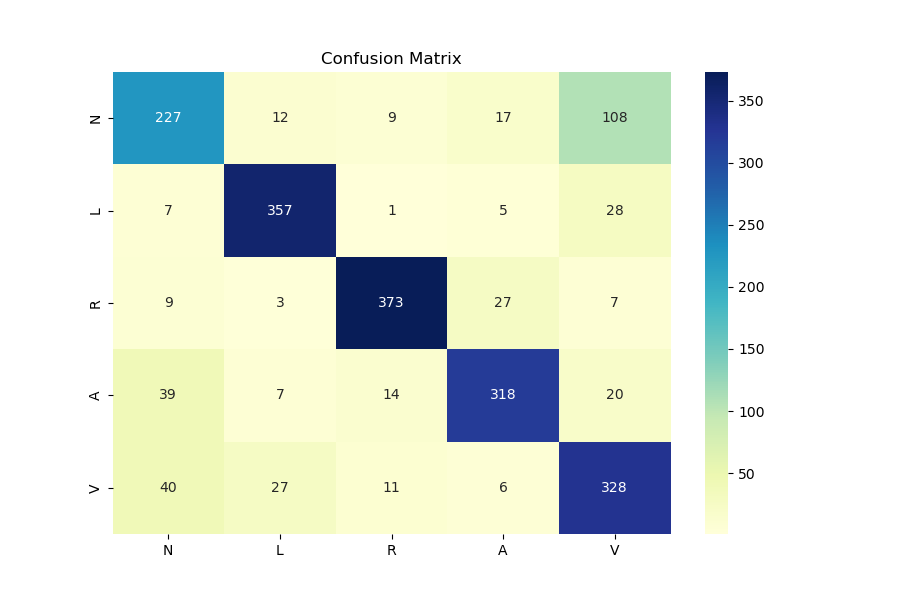

In [425]:
# visualize confusion matrix with seaborn heatmap

cm_matrix = pd.DataFrame(data=cm, columns=['N', 'L', 'R', 'A', 'V'], 
                                 index=['N', 'L', 'R', 'A', 'V'])

f, ax = plt.subplots(figsize=(9, 6))
g = sn.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Confusion Matrix')
